<a href="https://colab.research.google.com/github/AI-Junction/Histopathologic-Cancer-Detection/blob/master/Histopathologic-Cancer-Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [10]:
!pip install kaggle

In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

#filename = "/content/.kaggle/kaggle.json"
#filename = "/.kaggle/kaggle.json"
filename = "kaggle.json"
#os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!ls -lha kaggle.json



---x-wx--T 1 root root 65 Dec 15 17:29 kaggle.json


In [4]:
os.path.isdir("/root/.kaggle")

False

In [5]:
dir_kaggle = "/root/.kaggle"
if not os.path.isdir(dir_kaggle):
  !mkdir -p ~/.kaggle  
!cp kaggle.json ~/.kaggle/
os.path.isdir(dir_kaggle)

True

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
!kaggle competitions files -c histopathologic-cancer-detection

404 - Not Found


In [13]:
os.path.isdir("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection")

True

In [14]:
os.path.isfile("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv.zip")

True

In [15]:
os.path.isdir("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train")

True

In [0]:
if not os.path.isdir("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"):
  ! mkdir -p "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"



In [0]:
if not os.path.isfile("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv.zip"):
  !kaggle competitions download -c histopathologic-cancer-detection -f sample_submission.csv -p "/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"
  !kaggle competitions download -c histopathologic-cancer-detection -f train_labels.csv -p "/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"
  !kaggle competitions download -c histopathologic-cancer-detection -f test.zip -p "/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"
  !kaggle competitions download -c histopathologic-cancer-detection -f train.zip -p "/content/drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"


In [0]:
if not os.path.isfile("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv"):
  !unzip "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv.zip" -d "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection"

In [19]:
'''
if not os.path.isdir("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test"):
  !mkdir -p "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test"
  !unzip "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test.zip" -d "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test"
'''  

'\nif not os.path.isdir("drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test"):\n  !mkdir -p "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test"\n  !unzip "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test.zip" -d "drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/test"\n'

In [0]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 80000 # the number of images we use from each of the two classes

In [22]:
os.listdir('drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection')

['train_labels.csv',
 'sample_submission.csv.zip',
 'train_labels.csv.zip',
 'test.zip',
 'train.zip',
 'train']

In [23]:
os.path.isfile('drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv')

True

In [0]:
!chmod 600 'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv'

In [25]:
ls -l 'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv'

-rw------- 1 root root 9461084 Nov 15 23:48 'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv'


In [26]:
df_data = pd.read_csv('drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train_labels.csv', engine='python')

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220025, 2)


In [27]:
df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [0]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

In [0]:
import glob
train_files = glob.glob('drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train/*')

In [31]:
print(len(train_files))

38240


In [0]:
df_train_files = pd.DataFrame(train_files)

In [0]:
df_train_files.columns = ['filename']

In [0]:
df_train_files['tmp_col'] = 0

In [0]:
#df_data_new = df_data.loc[df['id'].isin(df_train_files)]

In [0]:
#df_train_files_tmp = df_train_files['filename'].split(".")

df_train_files_tmp = pd.DataFrame(df_train_files['filename'].apply(lambda x: x.split('.',1)))

In [0]:
df_train_files_tmp1 = [x[0] for x in df_train_files_tmp.filename[:]]

In [40]:
df_train_files_tmp1[0]

'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train/fc0c2ae132d4f17d80f0b198581a1e886a35fca0'

In [46]:
print(type(df_train_files_tmp1))

<class 'list'>


In [0]:
df_train_files_tmp2 = pd.DataFrame(df_train_files_tmp1) #.apply(lambda x: x.split('/',1))
df_train_files_tmp2.columns = ['filename']

In [51]:
type(df_train_files_tmp2)

pandas.core.frame.DataFrame

In [0]:
df_train_files_tmp3 = pd.DataFrame(df_train_files_tmp2['filename'].apply(lambda x: x.split('/',-1)))

In [0]:
df_train_files_tmp4 = [x[-1] for x in df_train_files_tmp3.filename[:]]

In [57]:
df_train_files_tmp4[:10]

['fc0c2ae132d4f17d80f0b198581a1e886a35fca0',
 'c4ce898102407039d4898e2f729d2ce4e231f831',
 '134440349cc5493ad04af8d9b857cc82ac40d3f9',
 '19e7a455376c46550947ea283c4d09fd4290c1e7',
 '08995e1337711ab002ec5147ca3dec3707cfad61',
 'bac802732be72520cf5b8f57142c997f7aed79ef',
 '8870ac289778c26d22a475936d021983996be5e9',
 'f30bdba9a608c13fa695fd7d6ccf1c8275e8d140',
 '1fb4c37a19975f61cf3f2465283068641ec28432',
 '4ea74936ac8b273ff8e070deb70d4cd436a272fd']

In [0]:
os.path.join('drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train', df_data.id[10]+'.tif')

'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train/a106469bbfda4cdc5a9da7ac0152927bf1b4a92d.tif'

In [0]:
os.path.isfile(os.path.join('drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train', df_data.id[10]+'.tif'))

False

TypeError: ignored

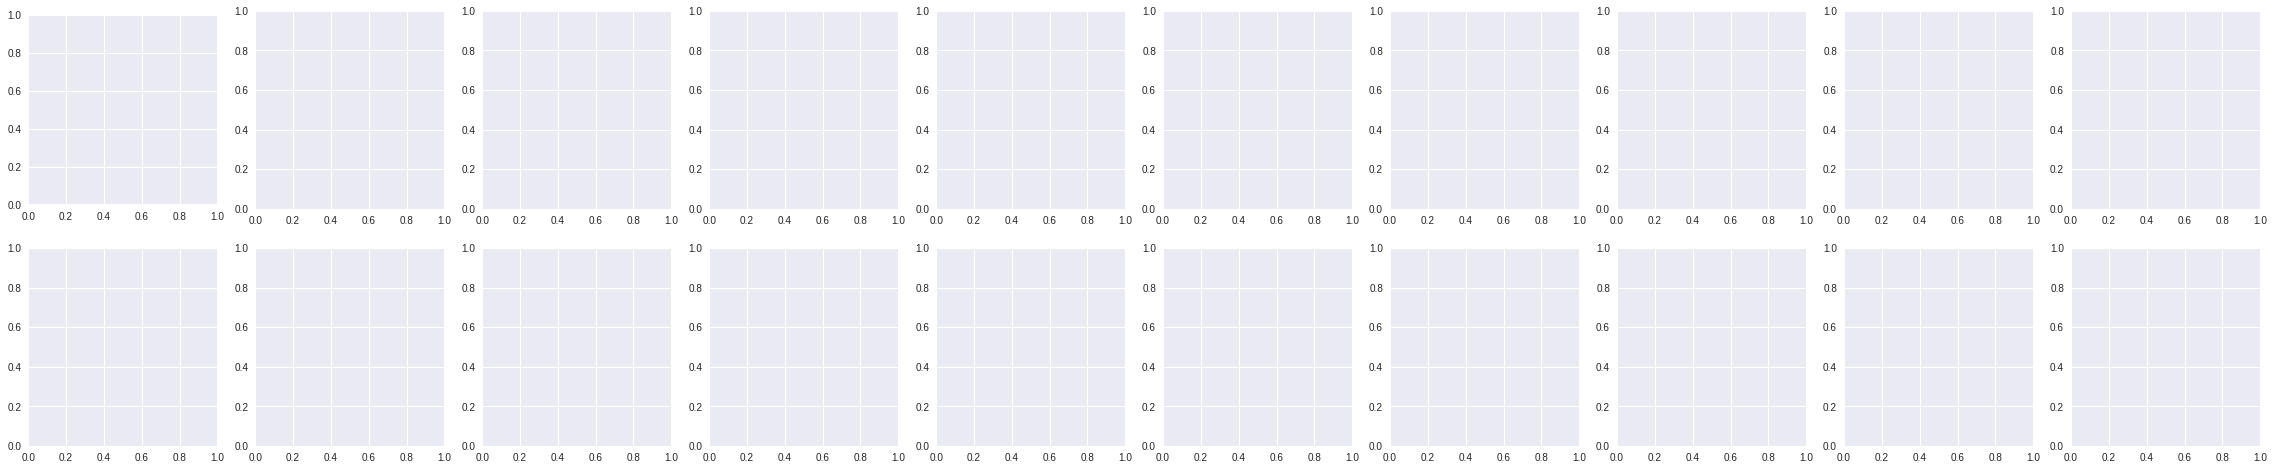

In [0]:
IMAGE_PATH = 'drive/My Drive/All ML Datasets/Histopathologic-Cancer-Detection/train' 

draw_category_images('label',10, df_data, IMAGE_PATH)